Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment
- [ ] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](http://archive.is/DelgE), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading

- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] Stacking Ensemble. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)

In [1]:
%%capture
import sys
import pandas as pd

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [2]:
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, plot_confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv', na_values=[0, -2.000000e-08]), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv')).set_index('id')

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv', na_values=[0, -2.000000e-08], index_col='id')

def wrangle(X):
  # Make a copy
  X = X.copy()
    
  # Extract components from date_recorded, then drop the original column
  X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
  X['year_recorded'] = X['date_recorded'].dt.year
  X['month_recorded'] = X['date_recorded'].dt.month
  X['day_recorded'] = X['date_recorded'].dt.day
  X = X.drop(columns='date_recorded')
  
  # Engineer feature: how many years from construction_year to date_recorded
  X['years'] = X['year_recorded'] - X['construction_year']
  X['years_MISSING'] = X['years'].isnull()

  # Scale water to population
  X['water_amount'] = X['amount_tsh']/X['population']

  # Drop high cardinality cols
  high_card_cols = [col for col in X.select_dtypes('object').columns
                    if X[col].nunique() > 300]
  X.drop(columns=high_card_cols, inplace=True)

  # Drop recorded_by (never varies)
  unusable_variance = ['recorded_by']
  X = X.drop(columns=unusable_variance)

  # Drop repeated columns
  duplicates = ['extraction_type_group', 'quantity', 'payment_type']
  X.drop(columns=duplicates, inplace=True)

  return X

train = wrangle(train)
test = wrangle(test)

In [5]:
# Create new binary target
train['needs_repair'] = train['status_group'].apply(lambda x: 1 if x != 'functional' else 0)
y = train['needs_repair']
X = train.drop(columns=['needs_repair', 'status_group'])

# Train-val split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Sanity check
assert len(X_train) + len(X_val) == len(X)

In [6]:
print('Baseline Accuracy:', y_train.value_counts(normalize=True).max())

Baseline Accuracy: 0.5425829668132747


In [10]:
from category_encoders import TargetEncoder
model = make_pipeline(TargetEncoder(min_samples_leaf=910),
                      SimpleImputer(strategy='mean'),
                      RandomForestClassifier(n_estimators=32,
                                             n_jobs = -1,
                                             random_state = 42,
                                             max_features = 0.8765850816178447,
                                             min_samples_leaf = 10,
                                             min_samples_split = 73,
                                             max_depth=30,
                                             ))
model.fit(X_train, y_train);

/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:726: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:726: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:726: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:726: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:726: RuntimeWarning: overflow encountered in exp
  resul

In [12]:
print('Training Accuracy',model.score(X_train, y_train))
print('Validation Accuracy',model.score(X_val, y_val))

Training Accuracy 0.8420421305162146
Validation Accuracy 0.8072390572390572


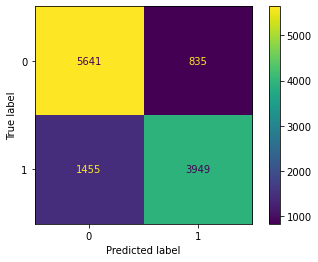

In [13]:
plot_confusion_matrix(model,
                      X_val,
                      y_val,
                      values_format = '.0f'
                      # display_labels=['no repair needed', 'needs repair'],
                      )

In [14]:
TP = 4163
FN = 1241
FP = 903
print('Recall:', TP / (TP+FN))
print('Precision:', TP / (TP+FP))

Recall: 0.7703552923760177
Precision: 0.821752862218713


In [15]:
print(classification_report(y_val, model.predict(X_val)))

              precision    recall  f1-score   support

           0       0.79      0.87      0.83      6476
           1       0.83      0.73      0.78      5404

    accuracy                           0.81     11880
   macro avg       0.81      0.80      0.80     11880
weighted avg       0.81      0.81      0.81     11880



In [16]:
n_inspections = 2000
y_val.value_counts(normalize=True).min()

0.4548821548821549

In [18]:
data = {'y_val': y_val,
        'y_pred': model.predict(X_val)}

results = pd.DataFrame(data)

mask = results['y_pred'] == 1
sample = results[mask].sample(n_inspections)

funds_wasted = (n_inspections - sample.y_val.sum())*100
funds_wasted = '$'+format(funds_wasted, ',d')

print(f'Inspections conducted: {n_inspections}')
print(f'Pumps repaired:', sample['y_val'].sum())
print('Funds wasted:', funds_wasted)

Inspections conducted: 2000
Pumps repaired: 1644
Funds wasted: $35,600


In [37]:
# Filter predictions by a confidence threshold
results = pd.DataFrame({
    'y_val': y_val,
    'y_pred_proba': model.predict_proba(X_val)[:,-1],
    })

threshold = 0.9
mask = results['y_pred_proba'] > threshold
sample = results[mask].sample(n_inspections)

funds_wasted = (n_inspections - sample.y_val.sum())*100
funds_wasted = '$'+format(funds_wasted, ',d')

print(f'Inspections conducted: {n_inspections}')
print(f'Pumps repaired:', sample['y_val'].sum())
print('Funds wasted:', funds_wasted)

Inspections conducted: 2000
Pumps repaired: 1963
Funds wasted: $3,700


In [39]:
# Get the 2,000 most confident predictions
most_confident = pd.DataFrame({
    'y_val': y_val,
    'y_pred_proba': model.predict_proba(X_val)[:,-1],
    })
most_confident = results.sort_values(by='y_pred_proba', ascending=False)
most_confident = most_confident.iloc[:n_inspections]

funds_wasted = (n_inspections - most_confident.y_val.sum())*100
funds_wasted = '$'+format(funds_wasted, ',d')

print(f'Inspections conducted: {n_inspections}')
print(f'Pumps repaired:', most_confident['y_val'].sum())
print('Funds wasted:', funds_wasted)

Inspections conducted: 2000
Pumps repaired: 1965
Funds wasted: $3,500


In [22]:
# Use scikit-learn to calculate TPR & FPR at various thresholds
fpr, tpr, thresholds = roc_curve(results.y_val, results.y_pred_proba)
# See the results in a table
pd.DataFrame({
    'False Positive Rate': fpr, 
    'True Positive Rate': tpr, 
    'Threshold': thresholds
})

,False Positive Rate,True Positive Rate,Threshold
0,0.000000,0.000000,2.000000
1,0.004015,0.278682,1.000000
2,0.004015,0.279238,0.995023
3,0.004015,0.279978,0.982857
4,0.007103,0.361029,0.980000
...,...,...,...
166,0.711859,0.981495,0.033333
167,0.792310,0.988342,0.020000
168,0.792464,0.988527,0.005714
169,0.792773,0.988527,0.002105


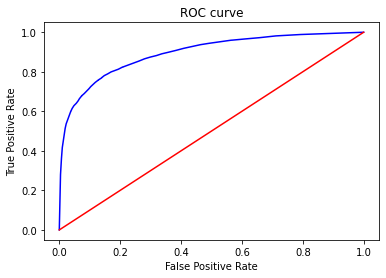

In [23]:
# See the results on a plot. 
# This is the "Receiver Operating Characteristic" curve
import matplotlib.pyplot as plt

plt.plot(fpr, tpr, color='blue')
plt.plot((0,1), (0,1), color='red')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');

In [24]:
# Use scikit-learn to calculate the area under the curve.
roc_auc_score(results.y_val, results.y_pred_proba)

0.8940486401078239